In [1]:
import os
import time
import pandas as pd
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
from sklearn.cluster import KMeans, DBSCAN
import multiprocessing

In [2]:
# Load from HDF5 file

project = os.path.realpath('./..')
datadir = os.path.join(project, 'data')

with pd.HDFStore(os.path.join(datadir, 'tweets_1M.h5')) as store:
    subset = store.tweets_subset

In [3]:
subset

,id,lat,lng,text,timeStamp,user_id
765125,384431028661526528,37.895140,-122.101307,Eagles fans are the most bipolar people ever h...,2013-09-29 21:34:34,248989689
308375,380727746852171777,37.933621,-122.336086,My emails tho http://t.co/ctPJWBbGHO,2013-09-19 16:19:03,234263178
181260,379675732739633152,37.785864,-122.403037,Mexican (@ Jessie Square) http://t.co/Dd2dU95exI,2013-09-16 18:38:43,556086698
355895,381122524378968064,37.409624,-121.937065,A hoe will be a hoe &amp; a nigga will be a ni...,2013-09-20 18:27:45,118594397
428001,381658997150851072,37.981324,-122.332549,There' goes my babbbbby,2013-09-22 05:59:30,585032848
295581,380557655283994625,37.226399,-121.777939,iOS7 makes me feel like I have a new phone...,2013-09-19 05:03:10,132380619
555490,382698211346874368,37.313653,-121.858618,you got what i need,2013-09-25 02:48:58,1194177008
562632,382726613458112512,37.241329,-121.889563,@Based_AztecGod thanks :),2013-09-25 04:41:50,172999986
40010,378370589984968704,37.998490,-121.276250,Lalabas na ang makiki pag inuman.😊🍻🍻 [pic] — h...,2013-09-13 04:12:33,451171945
269471,380393818626850817,37.752540,-122.412559,"Instagram derp on last tweet, let's try again:...",2013-09-18 18:12:08,14604338


In [4]:
# Convert the lat and lng columns to numpy array
data = subset.as_matrix(columns=['lat', 'lng'])

In [5]:
data

array([[  37.89513958, -122.10130728],
       [  37.93362077, -122.33608559],
       [  37.78586378, -122.40303722],
       ..., 
       [  37.27435   , -121.9513424 ],
       [  37.75474627, -122.42643232],
       [  37.3440942 , -121.80684226]])

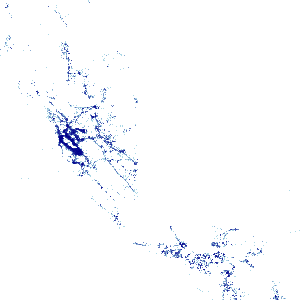

In [6]:
# Visualize points with datashader

cvs = ds.Canvas(plot_width=300, plot_height=300)
agg = cvs.points(subset, 'lng', 'lat')
tf.interpolate(agg)

In [7]:
# Prepare the k-means model object

k_means = KMeans(n_clusters=100,
                 init='k-means++',
                 n_init=10)

In [8]:
# Start timer
t0 = time.time()

# Fit the data and save timing
k_means.fit(data)
k_means_time = time.time() - t0
print k_means_time

# Add fitted label back into DataFrame
subset['cluster'] = k_means.labels_

20.6686899662


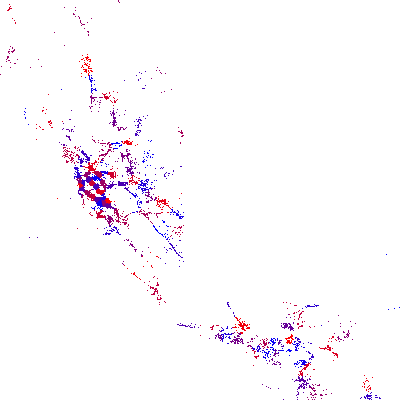

In [9]:
# Visualize points with datashader
cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(subset, 'lng', 'lat', ds.mean('cluster'))
tf.interpolate(agg, cmap=['red', 'blue'])